In [ ]:
!pip install packaging
!pip install git+https://github.com/rbracco/fastai2_audio.git

In [ ]:
import librosa
import torchaudio
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

In [ ]:
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
def tar_extract_at_filename(fname, dest):
    "Extract `fname` to `dest`/`fname`.name folder using `tarfile`"
    dest = Path(dest)/Path(fname).with_suffix('').name
    tarfile.open(fname, 'r:gz').extractall(dest)

In [ ]:
url = 'https://public-datasets.fra1.cdn.digitaloceanspaces.com/recordings.tar.gz'
data = untar_data(url, extract_func=tar_extract_at_filename)/'recordings'

In [ ]:
list((data).iterdir())[:5]

[Path('/root/.fastai/data/recordings.tar/recordings/0_jackson_47.wav'),
 Path('/root/.fastai/data/recordings.tar/recordings/2_jackson_2.wav'),
 Path('/root/.fastai/data/recordings.tar/recordings/7_yweweler_36.wav'),
 Path('/root/.fastai/data/recordings.tar/recordings/5_yweweler_16.wav'),
 Path('/root/.fastai/data/recordings.tar/recordings/8_jackson_2.wav')]

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)
a2s = DBMelSpec()
crop_1000ms = CropSignal(1000)
tfms = [crop_1000ms, a2s]

In [ ]:
a2s.settings

{'f_max': None,
 'f_min': 0.0,
 'hop_length': 512,
 'mel': True,
 'n_fft': 1024,
 'n_mels': 128,
 'pad': 0,
 'sample_rate': 16000,
 'stype': 'power',
 'to_db': True,
 'top_db': None,
 'win_length': 1024,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None}

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),
                 get_items=get_audio_files,
                 splitter=RandomSplitter(),
                 item_tfms = tfms,
                 get_y=lambda x: x.name[0])

In [ ]:
dbunch = auds.dataloaders(data, item_tfms = tfms, bs=64)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 16])

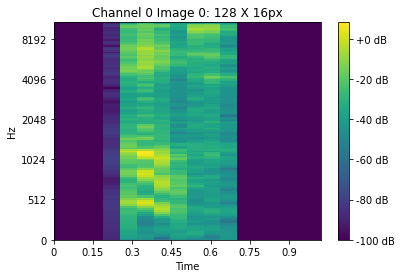

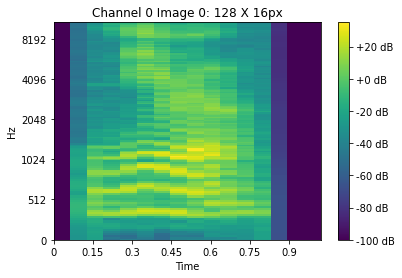

8
0


In [ ]:
dbunch.show_batch(max_n=2)

In [ ]:
learn = Learner(dbunch,
                xresnet18(),
                CrossEntropyLossFlat(),
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.0030199517495930195)

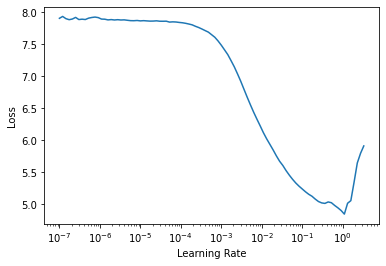

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.508214,3.917538,0.095000,00:03
1,3.017678,6.443586,0.125000,00:03
2,2.126312,1.758069,0.472500,00:03
3,1.404083,1.409222,0.617500,00:03
4,0.905442,0.396829,0.870000,00:03
5,0.595063,0.210521,0.937500,00:03
6,0.394021,0.132178,0.962500,00:03
7,0.255555,0.116150,0.972500,00:03
8,0.166845,0.107853,0.975000,00:03
9,0.111333,0.102718,0.975000,00:03


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(2, slice(1e-4, 4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.075574,0.518465,0.845000,00:03
1,0.076401,0.119830,0.962500,00:03


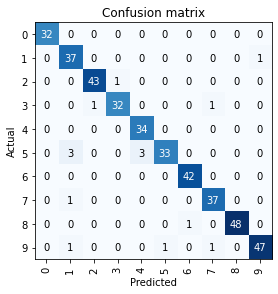

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
preds = learn.predict(data.ls()[21])
preds[0], data.ls()[21]

('8', Path('/root/.fastai/data/recordings.tar/recordings/8_theo_29.wav'))

In [ ]:
interp.most_confused(min_val=3)

[('5', '1', 3), ('5', '4', 3)]